In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

# Torch data interface to dynamic atlas

In [47]:
from dataset import *
from torchvision.transforms import Compose
transform=Compose([Reshape2DField(), ToTensor()])
cad = AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform)
sqh = AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform)
vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)

runt = AtlasDataset('WT', 'Runt', 'cyt2D', transform=transform)
vel = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform)

#hist = AtlasDataset('WT', 'histone-RFP', 'raw2D', transform=transform)
#vel = AtlasDataset('WT', 'histone-RFP', 'velocity2D', transform=transform)

print(len(runt), len(vel))

#dataset = AlignedDataset([sqh, cad, vel], ['sqh', 'cad', 'vel'])
dataset = AlignedDataset([runt, vel], ['runt', 'vel'])

batch = dataset[5]
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(key, batch[key])


dataset.df

100%|██████████| 6/6 [00:00<00:00, 614.51it/s]

498 498
embryo torch.Size([])
time torch.Size([])
genotype WT
runt torch.Size([1, 236, 200])
vel torch.Size([2, 236, 200])


,index_runt,embryoID,time,index_vel
0,0,202001150004,1.000000,0
1,1,202001150004,2.000000,1
2,2,202001150004,3.000000,2
3,3,202001150004,4.000000,3
4,4,202001150004,5.000000,4
...,...,...,...,...
493,493,202001141943,79.609360,493
494,494,202001141943,81.183102,494
495,495,202001141943,82.853797,495
496,496,202001141943,84.638666,496


# Does everything look like it should?

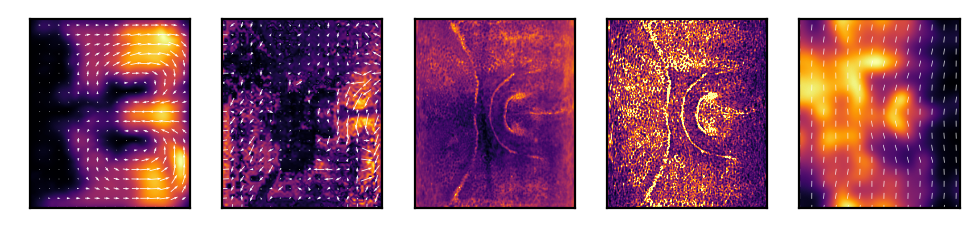

In [51]:
from plot_utils import *

#Origin=lower convention! Remember this
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['image.origin'] = 'lower'


fig, ax = plt.subplots(1, 5, dpi=200)

datadir = 'MLData/WT/ECad-GFP'
df = pd.read_csv(os.path.join(basedir, datadir, 'dynamic_index.csv'))
eID = df.embryoID.unique()[0]

vels = np.load(os.path.join(basedir, datadir, str(eID), 'velocity2D.npy'), mmap_mode='r')
pivl = np.load(os.path.join(basedir, datadir, str(eID), 'pivlab2D.npy'), mmap_mode='r')
raws = np.load(os.path.join(basedir, datadir, str(eID), 'raw2D.npy'), mmap_mode='r')
cyts = np.load(os.path.join(basedir, datadir, str(eID), 'cyt2D.npy'), mmap_mode='r')
tens = np.load(os.path.join(basedir, datadir, str(eID), 'tensor2D.npy'), mmap_mode='r')

tt = -1
plot_vector2D(ax[0], vels[tt], skip=12)
plot_vector2D(ax[1], pivl[tt], skip=12)
color_2D(ax[2], raws[tt], vmax_std=10)
color_2D(ax[3], cyts[tt], vmax_std=3)
plot_tensor2D(ax[4], tens[tt, :], skip=15)

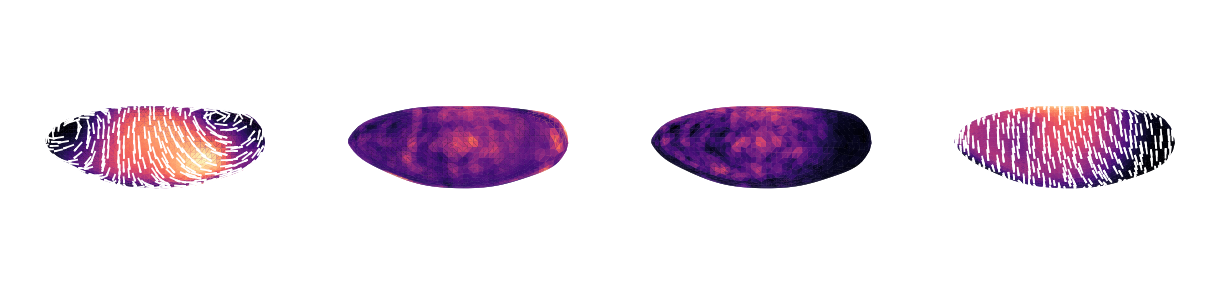

In [12]:
import matplotlib.pyplot as plt
import matplotlib 

import numpy as np
    
from plot_utils import *

datadir = 'MLData/WT/ECad-GFP'
df = pd.read_csv(os.path.join(basedir, datadir, 'dynamic_index.csv'))
eID = df.embryoID.unique()[0]

vels = np.load(os.path.join(basedir, datadir, str(eID), 'velocity3D.npy'), mmap_mode='r')
raws = np.load(os.path.join(basedir, datadir, str(eID), 'raw3D.npy'), mmap_mode='r')
cyts = np.load(os.path.join(basedir, datadir, str(eID), 'cyt3D.npy'), mmap_mode='r')
tens = np.load(os.path.join(basedir, datadir, str(eID), 'tensor3D.npy'), mmap_mode='r')

fig, ax = plt.subplots(1, 4, dpi=250, subplot_kw={'projection': '3d'})

tt = 35
plot_vector3D(ax[0], vels[tt])
color_mesh(ax[1], raws[tt])
color_mesh(ax[2], cyts[tt])
plot_tensor3D(ax[3], tens[tt])

# Keep all of our processed data within Dynamic Atlas

This is the testing notebook, see atlas_processing.py for the full code

In [52]:
'''
Metadata processing
'''
from scipy.io import loadmat


def convert_matstruct_to_csv(savedir):
    data = loadmat(os.path.join(savedir, 'dynamic_queried_sample.mat'))
    info = {}

    info['folder'] = [ df.astype('S') for df in data['folders'][0]]
    info['tiff'] = [ df.astype('S') for df in data['names'][0]]
    info['embryoID'] = [ df.astype('S') for df in data['embryoIDs'][0]]
    df = pd.DataFrame(info)
    df['folder'] = df['folder'].apply(lambda x: x[0].decode('utf-8'))
    df['tiff'] = df['tiff'].apply(lambda x: x[0].decode('utf-8'))
    df['embryoID'] = df['embryoID'].apply(lambda x: x[0].decode('utf-8'))

    times = [ dt.flatten()[:-1] for dt in data['times'][0]]
    df['time'] = times
    df = df.explode('time').reset_index(drop=True)
    df['eIdx'] = df.groupby(['embryoID']).cumcount()
    
    df.to_csv(os.path.join(savedir, 'dynamic_index.csv'), index=False)
    return df

'''
Pulling and reformatting data from Atlas
'''

from scipy.interpolate import RectBivariateSpline

piv_geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/Atlas_Data/embryo_geometry/embryo_rectPIVscale_fundamentalForms.mat')
pix_geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
Xpiv, Ypiv = piv_geometry['X0'][0], piv_geometry['Y0'][:, 0]
Xpix, Ypix = pix_geometry['XX'][0], pix_geometry['YY'][:, 0]

def collect_velocity_fields(savedir):
    '''
    We are LOCKING IN to IJ ordering
    Spatial ordering is [ROWS, COLUMNS] or [Y, X]
    Channel ordering is [VY, VX] corresponding to the spatial ordering
    
    Remember this when visualizing and lifting to 3D space
    '''
    if not os.path.exists(os.path.join(savedir, 'dynamic_index.csv')):
        warnings.warn('Index does not exist, processing matstruct')
        convert_matstruct_to_csv(savedir)
        
    warnings.warn('Collecting flow fields')
    
    df =  pd.read_csv(os.path.join(savedir, 'dynamic_index.csv'))
    for folder in df.folder.unique():
        ss = df[df.folder == folder]
        eID = ss.embryoID.iloc[0]
        
        velo_dir = os.path.join(folder, 'PIV_filtered')
        vels = []
        for eIdx in sorted(ss.eIdx):
            velo = loadmat(os.path.join(velo_dir, 'VeloT_medfilt_%06d.mat' % (eIdx+1)),
                           variable_names=['VX', 'VY'])
            
            if velo['VX'].shape[0] == Xpiv.shape[0]:
                X = Xpiv
            else:
                X = np.linspace(Xpiv.min(), Xpiv.max(), velo['VX'].shape[0])
            if velo['VX'].shape[1] == Ypiv.shape[0]:
                Y = Ypiv
            else:
                Y = np.linspace(Ypiv.min(), Ypiv.max(), velo['VX'].shape[1])
            
            vx = RectBivariateSpline(X, Y, velo['VX'])(Xpix, Ypix).T
            vy = RectBivariateSpline(X, Y, velo['VY'])(Xpix, Ypix).T
            vels.append(np.stack([vx, vy]))
        vels = np.stack(vels)
        np.save(os.path.join(folder, 'velocity2D'), vels)
from skimage.morphology import erosion, dilation, disk
cell_size = 8
structure = disk(cell_size)

def cytosolic_normalize(frame):
    background = dilation(erosion(frame, structure), structure)
    normalized = (frame - background) / background
    normalized[background == 0] = 0.
    return normalized

from scipy import ndimage
from skimage import transform
import windowed_radon as wr

size = 21
theta = np.linspace(0, 180, 45, endpoint=False)
radon_matrix = wr.get_radon_tf_matrix(size, theta=theta)

#sigma_space = 7 for sqh_ecad_dataset
#sigma_space = 12 otherwise (for some reason)
def anisotropy_tensor(frame, 
                      sigma_space=7,
                      threshold=1.75,
                      target_shape=(len(Ypix), len(Xpix))):
    m_tensor = wr.windowed_radon(frame, radon_matrix, theta=theta*np.pi/180, threshold_mean=threshold,
                                 method='global_maximum', return_lines=False)
    m_smooth = wr.filter_field(m_tensor, ndimage.gaussian_filter, kwargs={'sigma': sigma_space})
    m_smooth = wr.filter_field(m_smooth, transform.resize, kwargs={'output_shape': target_shape})
    #Correction to the radon transform code
    #Off-diagonal components are off by factor of -1 based on painting to 3d embryo
    #The reason is that we're using the origin='lower' convention
    #This is equivalent to the transform y->-y on the anisotropy tensor
    m_smooth[..., 0, 1] *= -1
    m_smooth[..., 1, 0] *= -1 
    
    #COMMIT to [M_YY, M_YX], [M_XY, M_XX] ordering
    tmatrix = np.array([[0, 1], [1, 0]])
    m_smooth = np.einsum('ik,...kl,lj->...ij', tmatrix, m_smooth, tmatrix)
    #Reshape
    m_smooth = m_smooth.transpose(2, 3, 0, 1)
    return m_smooth
        
from PIL import Image
from skimage.transform import resize

def collect_anisotropy_tensor(savedir, **wr_kwargs):
    '''
    We are LOCKING IN to IJ ordering
    Spatial ordering is [ROWS, COLUMNS] or [Y, X]
    Channel ordering is [M_YY, M_YX, M_XY, M_XX], 
        which corresponds to the spatial ordering
    
    Remember this when visualizing and lifting to 3D space
    '''    
    if not os.path.exists(os.path.join(savedir, 'dynamic_index.csv')):
        warnings.warn('Index does not exist, processing matstruct')
        convert_matstruct_to_csv(savedir)
        
    warnings.warn('Collecting anisotropy tensors')
    
    df =  pd.read_csv(os.path.join(savedir, 'dynamic_index.csv'))
    for folder in df.folder.unique():
        ss = df[df.folder == folder]
        eID = ss.embryoID.iloc[0]
        tiff_fn = os.path.join(folder, ss.tiff.iloc[0])
        movie = Image.open(tiff_fn)
        frames = np.sort(ss.eIdx.values)
        print('Embryo: ', eID, movie.n_frames, len(frames))
        raws = []
        cyts = []
        tensors = []
        for fId in tqdm(frames):
            movie.seek(fId)
            raw = np.array(movie)
            cyt = cytosolic_normalize(raw)
            
            tensor = anisotropy_tensor(cyt, **wr_kwargs)
            
            raws.append(raw)
            cyts.append(cyt)
            tensors.append(tensor)
        
        raws = np.stack(raws).astype(float)
        cyts = np.stack(cyts)
        tensors = np.stack(tensors)
        
        raws /= np.median(raws, axis=(1, 2), keepdims=True)
        cyts /= np.median(cyts, axis=(1, 2), keepdims=True)
        
        raws = resize(raws, [raws.shape[0], *tensors.shape[-2:]])
        cyts = resize(cyts, [cyts.shape[0], *tensors.shape[-2:]])
        
        np.save(os.path.join(folder, 'raw2D'), raws)
        np.save(os.path.join(folder, 'cyt2D'), cyts)
        np.save(os.path.join(folder, 'tensor2D'), tensors)
                
'''
3D embryo geometry handling
'''

emb_geometry = loadmat('../../MLData/embryo_geometry/embryo_3D_geometry.mat')
AP_space = emb_geometry['X'][0]
DV_space = emb_geometry['Y'][:, 0]
Z_AP = emb_geometry['Z'][0]
Phi_AP = emb_geometry['Phi'][::-1, 0]

z_emb = emb_geometry['z'][:, 0]
phi_emb = emb_geometry['ph'][:, 0]

e1 = emb_geometry['e2']
e2 = emb_geometry['e1']
Ei = np.stack([e1, e2], axis=-1).transpose(1, 2, 0)

def push_to_embryo_surface(savedir):
    if not os.path.exists(os.path.join(savedir, 'dynamic_index.csv')):
        warnings.warn('Index does not exist, processing matstruct')
        convert_matstruct_to_csv(savedir)
        
    warnings.warn('Pushing fields to embryo surface')
    
    df =  pd.read_csv(os.path.join(savedir, 'dynamic_index.csv'))
    for folder in df.folder.unique():
        ss = df[df.folder == folder]
        eID = ss.embryoID.iloc[0]
        files = glob.glob(os.path.join(savedir, str(eID)+'*2D.npy'))
        for file in files:
            data = np.load(file, mmap_mode='r')
            nTps = data.shape[0]
            data_emb = []
            for tt in tqdm(range(nTps)):
                frame = data[tt]
                header_shape = frame.shape[:-2]
                frame = frame.reshape([-1, *frame.shape[-2:]])

                f_APDV = np.stack([
                    RectBivariateSpline(Ypix, Xpix, frame[i])(DV_space, AP_space)
                    for i in range(frame.shape[0])])
                #We have to reverse the y axis here because RectBivariateSpline requires increasing order points
                f_emb = np.stack([
                    RectBivariateSpline(Phi_AP, Z_AP, f_APDV[i, ::-1])(phi_emb, z_emb, grid=False)
                    for i in range(frame.shape[0])])
                
                #Now convert using embryo surface basis vectors
                f_emb = f_emb.reshape([*header_shape, -1])
                
                if len(header_shape) == 1:
                    #Transforms like a vector
                    f_emb = np.einsum('ijv,jv->iv', Ei, f_emb)
                elif len(header_shape) == 2:
                    #Transforms like a tensor
                    f_emb = np.einsum('ikv,klv,jlv->ijv', Ei, f_emb, Ei)
                
                data_emb.append(f_emb)
                    
            data_emb = np.stack(data_emb)
            np.save(file[:-6]+'3D.npy', data_emb)
            
#savedir = '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/cad'
#savedir = '/project/vitelli/jonathan/REDO_fruitfly/MLData/WT/sqh'
#convert_matstruct_to_csv(savedir)
#collect_velocity_fields(savedir)
#collect_anisotropy_tensor(savedir)
#push_to_embryo_surface(savedir)

/project/vitelli/jonathan/REDO_fruitfly/src/atlas_processing/windowed_radon.py:300: RuntimeWarning: divide by zero encountered in true_divide
  line_weights = 1/(2*np.sqrt(e_len**2-(delta)**2))


In [53]:
def collect_pivlab_fields(savedir):
    '''
    We are LOCKING IN to IJ ordering
    Spatial ordering is [ROWS, COLUMNS] or [Y, X]
    Channel ordering is [VY, VX] corresponding to the spatial ordering
    
    Remember this when visualizing and lifting to 3D space
    '''
    if not os.path.exists(os.path.join(savedir, 'dynamic_index.csv')):
        warnings.warn('Index does not exist, processing matstruct')
        convert_matstruct_to_csv(savedir)
        
    warnings.warn('Collecting PIVlab flow fields')
    
    df =  pd.read_csv(os.path.join(savedir, 'dynamic_index.csv'))
    for folder in df.folder.unique():
        ss = df[df.folder == folder]
        eID = ss.embryoID.iloc[0]
        
        info_dir = os.path.join(folder, 'PIVlab')
        velo_dir = os.path.join(folder, 'PIVlab_filtered')
        vels = []
        for eIdx in sorted(ss.eIdx):
            info = loadmat(os.path.join(info_dir, 'VeloT_fine_%06d.mat' % (eIdx+1)),
                           variable_names=['X0', 'Y0'])
            velo = loadmat(os.path.join(velo_dir, 'VeloT_medfilt_fine_%06d.mat' % (eIdx+1)),
                           variable_names=['VX', 'VY'])
            #print(info['X0'][:, 0], info['Y0'][0], info['X0'].shape, velo['VX'].shape)

            vx = RectBivariateSpline(info['X0'][:, 0], info['Y0'][0], velo['VY'])(Xpix, Ypix).T
            vy = RectBivariateSpline(info['X0'][:, 0], info['Y0'][0], velo['VX'])(Xpix, Ypix).T
            vels.append(np.stack([vx, vy]))
        vels = np.stack(vels)
        np.save(os.path.join(folder, 'pivlab2D'), vels)

In [55]:
savedirs = [
    'WT/ECad-GFP',
    'WT/sqh-mCherry',
    'WT/moesin-GFP',
    'WT/Bazooka-GFP',
    'WT/Runt',
    'WT/Even_Skipped',
]

for savedir in savedirs:
    path = os.path.join('../../MLData', savedir)
    #df = convert_matstruct_to_csv(os.path.join('../../MLData', savedir))
    print(savedir, len(df))
    collect_velocity_fields(path)
    #collect_pivlab_fields(path)
    #collect_anisotropy_tensor(savedir)
    #push_to_embryo_surface(savedir)


WT/ECad-GFP 468


/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Collecting flow fields


WT/sqh-mCherry 468
WT/moesin-GFP 468
WT/Bazooka-GFP 468
WT/Runt 468
WT/Even_Skipped 468


In [9]:
savedirs = [
    'MLData/Even-Skipped[r13]/Spaghetti_Squash-GFP',
    'MLData/TollRM9/Spaghetti_Squash-GFP',
    #'MLData/twistMinus/sqhGFP',
    'MLData/optoRhoGEF2_sqhCherry/headIllumination',
    'MLData/optoRhoGEF2_sqhCherry/singlePlaneIllumination'
]

for savedir in savedirs:
    df = convert_matstruct_to_csv(savedir)
    print(savedir, len(df))
    #collect_velocity_fields(savedir)
    collect_anisotropy_tensor(savedir)
    #push_to_embryo_surface(savedir)


MLData/Even-Skipped[r13]/Spaghetti_Squash-GFP 279


/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: Collecting anisotropy tensors


Embryo:  202101231300 60 59


100%|██████████| 59/59 [06:18<00:00,  6.41s/it]


Embryo:  202107071520 67 66


 76%|███████▌  | 50/66 [05:20<01:42,  6.42s/it]/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide
/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 66/66 [07:03<00:00,  6.41s/it]


Embryo:  202107071645 70 69


100%|██████████| 69/69 [07:21<00:00,  6.40s/it]


Embryo:  [DEPRECATED] 202103141755 38 37


100%|██████████| 37/37 [03:57<00:00,  6.41s/it]


Embryo:  [DEPRECATED] 202103142135 49 48


100%|██████████| 48/48 [05:07<00:00,  6.41s/it]


MLData/TollRM9/Spaghetti_Squash-GFP 71
Embryo:  202101121810 72 71


100%|██████████| 71/71 [07:34<00:00,  6.40s/it]


MLData/optoRhoGEF2_sqhCherry/headIllumination 275
Embryo:  202011241330 40 39


100%|██████████| 39/39 [04:09<00:00,  6.39s/it]


Embryo:  202102241100 60 59


100%|██████████| 59/59 [06:19<00:00,  6.44s/it]


Embryo:  202102241215 60 59


100%|██████████| 59/59 [06:18<00:00,  6.41s/it]


Embryo:  202102250915 60 59


100%|██████████| 59/59 [06:18<00:00,  6.42s/it]


Embryo:  202102251100 60 59


100%|██████████| 59/59 [06:19<00:00,  6.42s/it]


MLData/optoRhoGEF2_sqhCherry/singlePlaneIllumination 116
Embryo:  202011251120 40 39


100%|██████████| 39/39 [04:09<00:00,  6.40s/it]


Embryo:  202011251415 39 38


100%|██████████| 38/38 [04:03<00:00,  6.41s/it]


Embryo:  202011251450 40 39


100%|██████████| 39/39 [04:10<00:00,  6.41s/it]
